# Building reference objects for a set of multidimensional time series

# Задание A, D
## Abstract, Literature, LinkReview

https://github.com/Intelligent-Systems-Phystech/2018-Project-2/blob/master/Iskhakov2018Project2/paper.pdf

# Задания I, P, B
## Общая постановка задачи, обзор литературы, описание выборки и предлагаемых алгоритмов

### Цель, мотивация, предмет исследования, описание данных

Одним из приложений методов машинного обучения является задача нахождения зависимостей во временных рядах. В данном проекте предметом исследования являются временные рядов, полученных с датчиков с помощью ЭЭГ головного мозга мартышки, которой демонстрировались заранее подготовленные видеоролики разного формата, содержание которых нацелено на возбуждение различных нервных центров головного мозга. Цель данного проекта заключается в анализе собранных данных и поиске зависимости между данными ЭЭГ и эмоциями животного [1, 2].

###  Формальная постановка задачи
Требуется восстановить зависимость y = F(X), где y --- номер класса, соответсвующий определнному видеоролику, демонстируемому животному, а X -- многомерный временной ряд данных ЭЭГ за некоторый промежуток времени. Поскольку изначально мы имеем размеченную выборку, применяется машинное обучение с учителем.

### Основные трудности в исследуемой проблеме
В проекте возникают все трудности, традиционно связанные с анализом 
- биологических данных
- временных рядов

Данные ЭЭГ не поддаются ручной интерпретации, сравнению, анализу. Данные представляют из себя временные ряды огромной длительности, не пригодные для непосредственного применения классических алгоритмов машинного обучения. Основная трудность состоит в грамотном представлении входных данных, выделения из них релевантных признаков и поиске оптимального набора параметров сэмплирования, гиперпараметров используемых моделей и др. [3] 
 
### Предлагаемое решение

Изначально предложенный подход заключается в использовании метрического алгоритма классификации. В качестве функции расстояния предлагается использовать DTW как один из наиболее совершенных методов сравнения временных рядов [4]. Для решения проблемы вычислительной сложности предлагается использование алгоритма DBA построения центроидов. После построения центроидов вычисление расстояний от классифициремого объекта до всех объектов каждого из классов заменяется вычислением расстояний до их центроидов (или нескольких центроидов кластеров, выделенных в пределах каждого класса). В качестве альтернативного подхода рассматривается использование LSTM нейронной сети для решения задачи классификации. Использование сверточных, рекуррентных, LSTM сетей является на сегодняшний день одним из самых распротсраненных и успешных методов анализа временных рядов.

### Критерии качества
Classification accuracy --- основная метрика качества. Предполагается достижение точности >99% на синтетических данных и значительного улучшения качества по сравнению с random classifier для реальных данных (с учетом сложности анализа и зашумленности биологических данных такие критерии представляются разумными для простого проекта).

### Ссылки на литературу


[1] Marcel, S. Person authentication using brainwaves (eeg) and maximum a posteriori model adaptation / S. Marcel, J. d. R. Mill ́an // Pattern Analysis and Machine Intelligence, IEEE Transactions on. — 2007. — Vol. 29, no. 4. — Pp. 743–752.

[2] Alomari, M. H. Automated classification of l/r hand movement eeg signals using advanced feature extraction and machine learning / M. H. Alomari, A. Samaha, K. AlKamha // arXiv preprint arXiv:1312.2877. — 2013.

[3] Wei, L. Semi-supervised time series classification / L. Wei, E. Keogh // Proceedings of the 12th ACM SIGKDD International Conference on Knowledge Discovery and
– 22 –
Data Mining.— KDD ’06.— New York, NY, USA: ACM, 2006.— Pp. 748–753.

[4] Jeong, Y.-S. Weighted dynamic time warping for time series classification / Y.- S. Jeong, M. K. Jeong, O. A. Omitaomu // Pattern Recognition. — 2011. — Vol. 44, no. 9.— Pp. 2231 – 2240.— Computer Analysis of Images and Patterns.

# Necessary imports

In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, confusion_matrix

import keras
import keras.layers as L
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


# Read source sensors EEG monkey brain data
source: http://neurotycho.org/emotional-movie-task

In [2]:
DIRECTORY = "../data/20110706"
NSENSORS = 128
monkey_data = \
    pd.DataFrame({i: scipy.io.loadmat(f'{DIRECTORY}/LFP_ch{i}.mat')['LFP'][0]
                  for i in range(1, 1 + NSENSORS)})

In [3]:
movies_data = pd.Series(index=scipy.io.loadmat(f"{DIRECTORY}/Movie_start_time.mat")['Movie_start_time'][0],
                        data=scipy.io.loadmat(f"{DIRECTORY}/Task_info.mat")['SessionData'][0][0][3].reshape(-1))
movies_data[0] = 0
monkey_data['movie'] = movies_data
monkey_data['movie'] = monkey_data['movie'].fillna(method='ffill')

# Window size choice

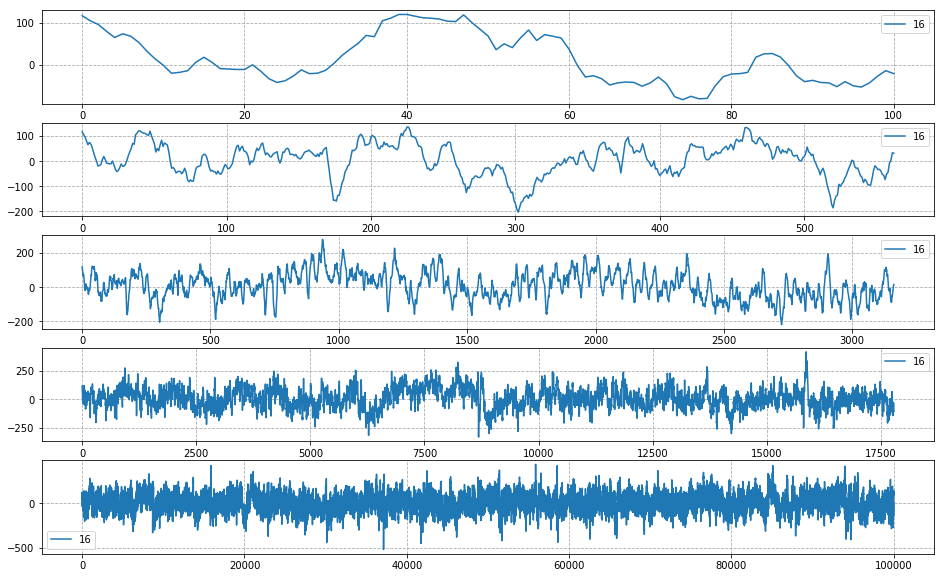

In [4]:
N = 5
fig, axes = plt.subplots(figsize=(16, 10), nrows=N, ncols=1)
axes = iter(axes)

for size in np.logspace(2, 5, N):
    ax = next(axes)
    monkey_data[[16]].loc[0:size].plot(ax=ax)
    ax.grid(color='#AAAAAA', ls='--')

In [5]:
SAMPLE_SIZE = 300
OVERLAP = 20

# Задание D
## Распланировать базовый вычислительный эксперимент, построить синтетическую выборку

1. Основная цель эксперимента: протестировать выбранные алгоритмы на синтетических легко классифицируемых данных. Для решения данной задачи сгенерируем синтетическую выборку в виде синусоид с различными периодами (каждому классу соответствует определенная частота) сдвинутые по фазе (каждому каналу соответсвует опредленная фаза).
2. Синтетическая выборка:
    1. Данные вручную сгенерированы так, чтобы на них можно было протестировать работу алгоритмов классификации.
    2. Размер синтетических данных соответсвует размеру исходных данных.
3. Параметры обработки данных для базовой модели:
    1. Размер временного ряда (при сэплировании): 300 точек
    2. Наложение: 20 точек
    3. Режимы работы DTW: с свободными концами (open-ends) и зафиксированными (fixed-ends)
    4. Паттерн DTW: `AsymmetricP05`
    5. Классификация: K-means metric classification, считаем DTW-расстояние между точками в обучающей выборке и точкой в тестовой и выбираем тот класс, которому соответствует наименьшее среднее расстояние. 

### Generate synthetic data for testing & comparison

In [7]:
labels = monkey_data['movie'].unique()

In [8]:
nrows = int(np.ceil(len(monkey_data) / len(labels)))
parts = [
    np.tile(np.arange(0, nrows), (NSENSORS, 1)).T * x / 200 +
    np.tile(np.arange(0, NSENSORS), (nrows, 1))
    for x in labels
] 

In [9]:
synthetic_data = pd.DataFrame(
    data=np.sin(np.concatenate(parts, axis=0)[0:len(monkey_data)]),
    columns=monkey_data.columns.drop('movie'),
    index=monkey_data.index
)

In [10]:
movies = np.concatenate(
    [np.repeat(label, nrows) for label in labels]
)

synthetic_data['movie'] = movies[0:len(monkey_data)]

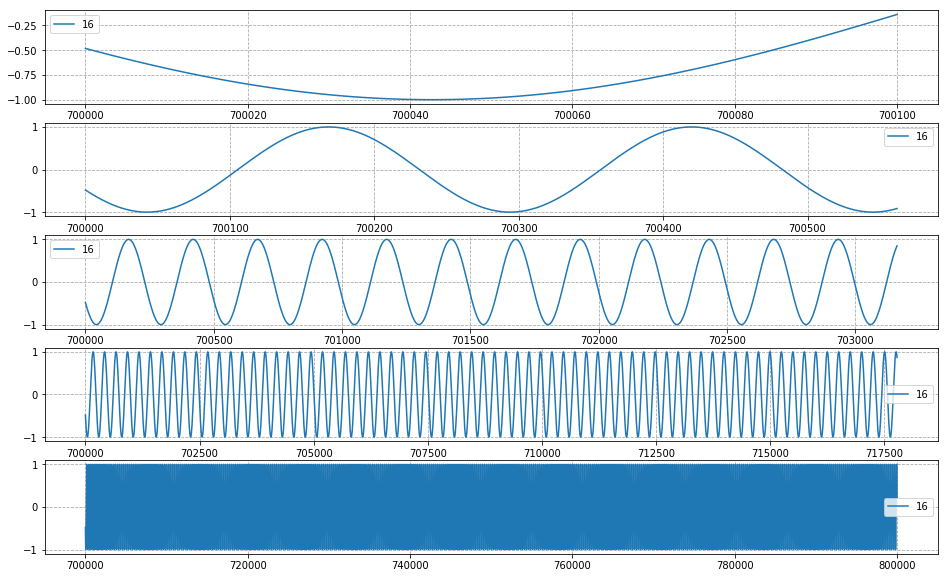

In [15]:
N = 5
fig, axes = plt.subplots(figsize=(16, 10), nrows=N, ncols=1)
axes = iter(axes)

for size in np.logspace(2, 5, N):
    ax = next(axes)
    synthetic_data[[16]].loc[700000 : 700000 + size].plot(ax=ax)
    ax.grid(color='#AAAAAA', ls='--')

### Preprocessing the data

In [12]:
def process_raw_df(raw_df):
    # Split into series of `SAMPLE_SIZE` length with `OVERLAP` overlap
    step = SAMPLE_SIZE - OVERLAP
    series = [raw_df.loc[start : start + SAMPLE_SIZE - 1].reset_index(drop=True)
              for start in range(0, len(raw_df) - SAMPLE_SIZE - 1, step)]

    # Concat into convenient dataframe
    data = pd.concat(series, keys=range(0, len(series)))
    data.index.names = ['datapoint', 't']

    # Select channels if needed
    # data = data.loc[:, [3, 4, 5, 6, 7, 'movie']]

    return data

### Here we choose which data to process, real or synthetic

In [13]:
data = process_raw_df(monkey_data)

### Test DTW with various parameters

In [16]:
from dtwalign import dtw, dtw_low
import dtwalign

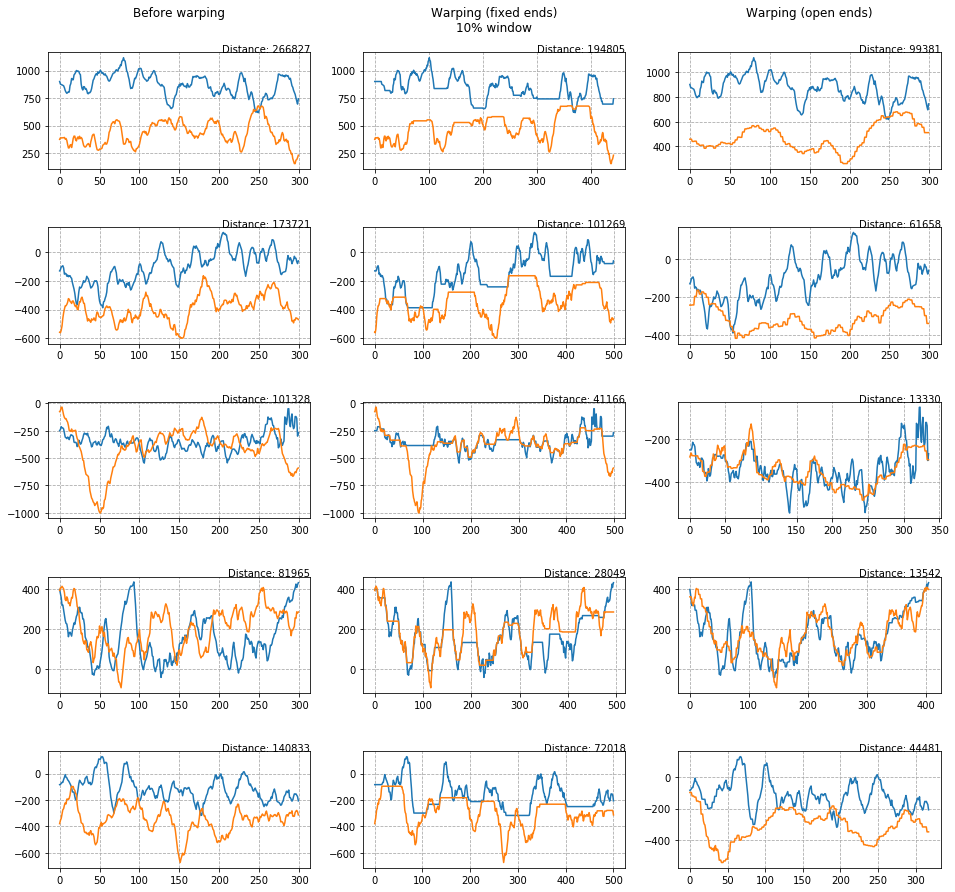

In [17]:
N = 5

fig, axes = plt.subplots(figsize = (16, 3*N) , nrows=N, ncols=3)

axes[0][0].set_title('Before warping\n\n')
axes[0][1].set_title('Warping (fixed ends)\n10% window\n')
axes[0][2].set_title('Warping (open ends)\n\n')

axes = iter(axes)

for n1, n2 in np.random.randint(0, len(data.index.unique('datapoint')), (N, 2)):
    ax = next(axes)
    x = data.loc[n1, [7]].values
    y = data.loc[n2, [7]].values
    
    def _plot_aligned(ax, x, y, x_path, y_path, distance):
        ax.grid(color='#aaaaaa', ls='--')
        
        ax.plot(x[x_path])
        ax.plot(y[y_path])
        ax.text(ax.get_xlim()[1], ax.get_ylim()[1], f"Distance: {distance:.0f}", ha='right')
        
    res = dtw(x, y, window_type="sakoechiba", window_size=0)
    _plot_aligned(ax[0], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)

    res = dtw(x, y, window_type="sakoechiba", window_size=SAMPLE_SIZE*0.1)
    _plot_aligned(ax[1], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
    X = cdist(x, y, metric="euclidean")
    res = dtw_low(X, open_end=True, open_begin=True,
              window=dtwalign.window.NoWindow(len(x), len(y)),
              pattern=dtwalign.step_pattern.AsymmetricP05())
    
    _plot_aligned(ax[2], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
plt.subplots_adjust(hspace=0.5)

### DTW pattern used

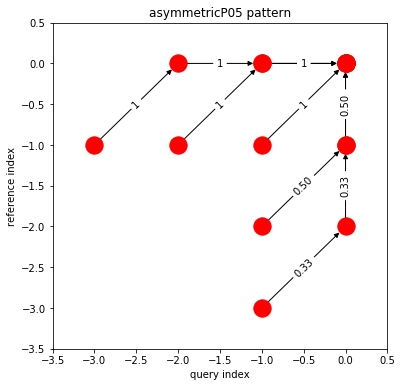

In [18]:
dtwalign.step_pattern.AsymmetricP05().plot()

# Задания E, H, M
## Запустить базовый эксперимент, проанализировать его результаты.

1. Стратегия разбиения скользящего контроля: используется случайная подвыборку из датасета
2. Задача оптимизации параметров: после получении адекватного качества базовой модели на синтетических данных, запустим случайный поиск по сгенерированной сетке параметров для подбора параметров сэмплирования, метрики расстояния (DTW)
3. Критериев качества модели: результат лучше случайного для реальных данных, $accuracy > 99\%$ для синтетических данных
4. Получен набор значений внешних критериев на обучении и контроле: для random прогнозирования: $accuracy = 14.2\%$

В качестве сравнительной к метрической кластеризации модели выберем LSTM нейронную сеть, которая часто используется для анализа временных рядов. Оценим ее точность для начала на синтетической выборке, затем на реальной выборке данных. 


### Оптимизация гиперпараметров моделей

![Overlap parameter optimization](overlap.png)
![Length parameter optimization](length.png)

### Полученные результаты при оптимизированных гиперпараметрах

#### Метрическая классификация:
- синтетические данные, евклидова норма: 30%
- синтетические данные, DTW: 70%
- реальные данные, евклидова норма: 14.0%
- реальные данные, DTW: 15.2%

#### LSTM
- синтетические данные: 100%
- реальные данные: 19.6%

### Выводы
Результаты показывают, что алгоритм метрической классификации с метрикой DTW не является подходящим для решения поставленной задачи без дополнительных оптимизаций. Это связано с тем, что метрические алгоритмы не всегда могут работать для биологических данных, поскольку временные ряды данных ЭЭГ при одном и том же характере активности голлвного мозга могут быть совершенно непохожими "внешне" (то есть и с "точки зрения" DTW), но могут иметь одинаковое среднее (или скользящее среднее) распределение интенсивности сигнала по датчикам, ожинаковую скользящую дисперсию и т.д. Поэтому для применения метрических (да и других) алгоритмов требуется дополнительный feature exctraction с привлечением дополнительных исследований о характере данных ЭЭГ.

Вместе с тем, простая LSTM-сеть показывает несколько лучшие результаты, что лишь подтверждает сделанные выводы. Однако имеется еще огромное поле для оптимизаций парметров, сложности сети, аугментации входных данных, их преобразования, генерации дополнительных признаков.

### Metric classification

In [ ]:
def dtw_distance(x, y):
    """Calculate DTW distance between N-dim time series"""
    x = x
    y = y
    X = cdist(x, y, metric="euclidean")
    return(dtw_low(X, open_end=True, open_begin=True, dist_only=True,
                   window=dtwalign.window.NoWindow(len(x), len(y)),
                   pattern=dtwalign.step_pattern.AsymmetricP05()).distance)

### Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
datapoints = data.index.unique('datapoint')

In [ ]:
points_train, points_test = train_test_split(datapoints,
                                             test_size=1168,
                                             train_size=7000,
                                             random_state=54645)

In [ ]:
train, test = data.loc[points_train], data.loc[points_test]
X_train, y_train = train.drop('movie', axis=1), train['movie'].groupby('datapoint').first()
X_test,  y_test  = test .drop('movie', axis=1), test ['movie'].groupby('datapoint').first()

### Metric classification
Fill a `distances` matrix of DTW distances between points of train set and points of test set, then choose a class with minimal mean distance

In [ ]:
distances = pd.DataFrame(index=points_train, columns=points_test)
distances['movie'] = y_train

In [ ]:
for point_test in tqdm_notebook(points_test):
    for point_train in points_train:
        distance = np.linalg.norm(X_test.loc[point_test].values - 
                                  X_train.loc[point_train].values)

        distances.loc[point_train, point_test] = distance

In [ ]:
y_pred = distances.astype('float64').groupby('movie').mean().idxmin()

In [ ]:
accuracy_score(y_test, y_pred)

### KERAS LSTM

### Prepare data for LSTM
Note that X_train, Y-train are changed now

In [ ]:
def prepare_for_NN(X, y, time_cut):
    """Produce 3-dimensional tensor for NN"""
    points_train = X.index.unique('datapoint')
    return (
        X.loc[(slice(None), slice(0, time_cut - 1)), :]
        .values.reshape(len(points_train), NSENSORS, time_cut)
        .swapaxes(1, 2)
        .astype(int),
        
        y.values.astype(int)
    )

In [ ]:
X_train, y_train = prepare_for_NN(X_train, y_train, 256)
X_test, y_test = prepare_for_NN(X_test, y_test, 256)

In [ ]:
# Normalise data
normaliser = X_train.max() - X_train.min()
X_train = X_train / normaliser
X_test = X_test / normaliser

In [ ]:
model = Sequential(
    [
        L.LSTM(units=64, return_sequences=True), # input LSTM layer
        L.LSTM(units=128), # hidden LSTM layer
        L.Dense(units=7, activation='softmax'), # dense layer for 7-class output
    ]
)

In [ ]:
# Smaller step => small time series values
model.compile(optimizer=keras.optimizers.Adam(lr=1e-6),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
y_cat_train = keras.utils.to_categorical(y_train, num_classes=7)
y_cat_test = keras.utils.to_categorical(y_test, num_classes=7)

In [ ]:
# Fit model and see accuracy increase with epochs
model.fit(X_train, y_cat_train, batch_size=32,
          epochs=100,
          validation_data=(X_test, y_cat_test))

# Задание R
## Технический отчет